# Data Augmentation for Brain Tumor MRI Dataset
This notebook performs data augmentation on the brain tumor MRI dataset using PyTorch transforms, and summarizes the resulting dataset.

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from PIL import Image
import cv2
import os
import imutils
import matplotlib.pyplot as plt
from os import listdir, makedirs
import time
import numpy as np
import random
from tqdm import tqdm

%matplotlib inline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Path and Parameter Setup
Defines image dimensions and sets up directory paths for original and augmented data.

In [2]:
IMG_WIDTH = 240
IMG_HEIGHT = 240

yes_path = os.path.join('Brain-Tumor-Detection-Dataset', 'yes')
no_path = os.path.join('Brain-Tumor-Detection-Dataset', 'no')
augmented_data_path = 'augmented_data'

## Mild Data Augmentation Transform
Defines a mild augmentation pipeline (rotation, flip, slight brightness/contrast) suitable for medical images.

In [3]:
def get_mild_transform():
    return transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

## Data Augmentation Function
Applies the augmentation transform to all images in the dataset, saving the results to the output directory.

In [4]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    os.makedirs(save_to_dir, exist_ok=True)
    transform = get_mild_transform()
    files = [f for f in os.listdir(file_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for fname in files:
        img_path = os.path.join(file_dir, fname)
        try:
            img = Image.open(img_path).convert('L')
            for i in range(n_generated_samples):
                augmented = transform(img)
                # Convert back to PIL for saving
                save_img = transforms.ToPILImage()(augmented)
                save_img.save(os.path.join(save_to_dir, f"{os.path.splitext(fname)[0]}_aug_{i+1}.png"))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

## Helper: Elapsed Time Formatting
Formats elapsed time for reporting augmentation duration.

In [5]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

## Run Data Augmentation
Executes the augmentation process for both tumor and non-tumor images, and reports elapsed time and GPU memory status.

In [6]:
print("Starting data augmentation...")
print(f"Source paths: {yes_path}, {no_path}")
print(f"Output path: {augmented_data_path}")

start_time = time.time()

print("\nAugmenting tumor images (yes class)...")
augment_data(file_dir=yes_path, n_generated_samples=1, save_to_dir=os.path.join(augmented_data_path, 'yes'))

print("\nAugmenting non-tumor images (no class)...")
augment_data(file_dir=no_path, n_generated_samples=1, save_to_dir=os.path.join(augmented_data_path, 'no'))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"\nTotal elapsed time: {hms_string(execution_time)}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU memory cleared") 

Starting data augmentation...
Source paths: Brain-Tumor-Detection-Dataset\yes, Brain-Tumor-Detection-Dataset\no
Output path: augmented_data

Augmenting tumor images (yes class)...

Augmenting non-tumor images (no class)...

Total elapsed time: 00:00:34
GPU memory cleared


## Dataset Summary Function
Calculates and prints the distribution of tumor and non-tumor images in the augmented dataset.

In [7]:
def data_summary(main_path):
    """
    Calculate and display data distribution summary for tumor and non-tumor images.
    """
    yes_path = os.path.join(main_path, 'yes')
    no_path = os.path.join(main_path, 'no')

    # Check if directories exist
    if not os.path.isdir(yes_path):
        print(f"Warning: Directory not found: {yes_path}")
        m_pos = 0
    else:
        m_pos = len([f for f in os.listdir(yes_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    if not os.path.isdir(no_path):
        print(f"Warning: Directory not found: {no_path}")
        m_neg = 0
    else:
        m_neg = len([f for f in os.listdir(no_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    m = m_pos + m_neg
    if m == 0:
        print("No images found in the dataset.")
        return

    pos_prec = (m_pos * 100.0) / m
    neg_prec = (m_neg * 100.0) / m

    print(f"\nDataset Summary:")
    print(f"Total examples: {m}")
    print(f"Tumor examples (yes): {m_pos} ({pos_prec:.1f}%)")
    print(f"Non-tumor examples (no): {m_neg} ({neg_prec:.1f}%)")

    # Calculate balance
    balance_ratio = m_pos / m_neg if m_neg > 0 else float('inf')
    print(f"Balance ratio (tumor/non-tumor): {balance_ratio:.2f}")

    if 0.8 <= balance_ratio <= 1.2:
        print("Dataset is well balanced!")
    elif balance_ratio > 1.2:
        print("Dataset is slightly imbalanced (more tumor cases)")
    else:
        print("Dataset is slightly imbalanced (more non-tumor cases)")

data_summary('augmented_data')


Dataset Summary:
Total examples: 3000
Tumor examples (yes): 1500 (50.0%)
Non-tumor examples (no): 1500 (50.0%)
Balance ratio (tumor/non-tumor): 1.00
Dataset is well balanced!


## Post-Augmentation Data Summary
Displays the class balance after augmentation. 

In [8]:
print("Tumorous and non-tumorous examples after performing data augmentation:")
print("=" * 60)

data_summary(augmented_data_path)

Tumorous and non-tumorous examples after performing data augmentation:

Dataset Summary:
Total examples: 3000
Tumor examples (yes): 1500 (50.0%)
Non-tumor examples (no): 1500 (50.0%)
Balance ratio (tumor/non-tumor): 1.00
Dataset is well balanced!


## Visualize Augmented Samples

- Displays a grid of sample augmented images for both tumor and non-tumor classes.
- Helps verify the quality and diversity of the augmentation process.
- Ensures that augmented images retain relevant anatomical features and are suitable for model training.

Visualizing sample augmented images...


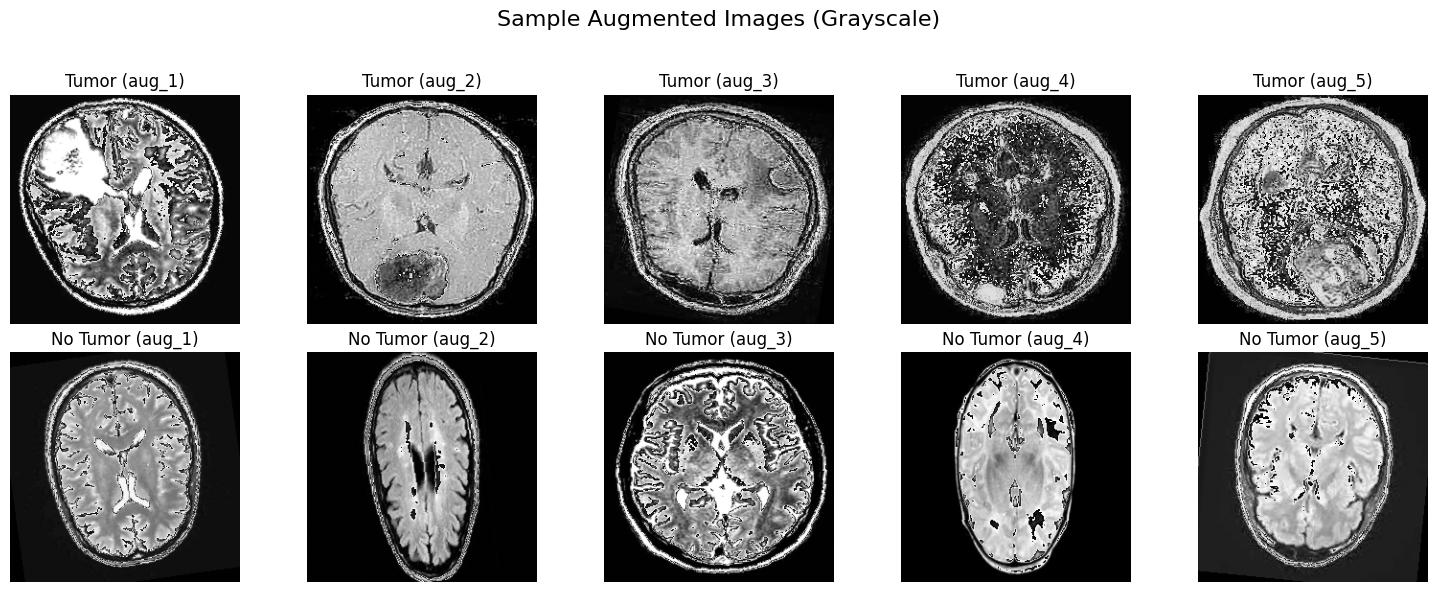

In [10]:
def visualize_augmented_samples(augmented_path, num_samples=5):
    yes_path = os.path.join(augmented_path, 'yes')
    no_path = os.path.join(augmented_path, 'no')

    # Get augmented files (sorted for consistency)
    yes_files = sorted([f for f in os.listdir(yes_path) if 'aug_' in f and f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:num_samples]
    no_files = sorted([f for f in os.listdir(no_path) if 'aug_' in f and f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))
    fig.suptitle('Sample Augmented Images (Grayscale)', fontsize=16)

    # Tumor (yes) images
    for i, filename in enumerate(yes_files):
        img_path = os.path.join(yes_path, filename)
        try:
            img = Image.open(img_path).convert('L')
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'Tumor (aug_{i+1})')
        except Exception as e:
            axes[0, i].set_title('Error')
            axes[0, i].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[0, i].axis('off')

    # Non-tumor (no) images
    for i, filename in enumerate(no_files):
        img_path = os.path.join(no_path, filename)
        try:
            img = Image.open(img_path).convert('L')
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'No Tumor (aug_{i+1})')
        except Exception as e:
            axes[1, i].set_title('Error')
            axes[1, i].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Tumor', fontsize=14)
    axes[1, 0].set_ylabel('No Tumor', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Visualizing sample augmented images...")
visualize_augmented_samples('augmented_data', num_samples=5) 

## GPU Performance Metrics

- Reports GPU device information, memory usage, and processing speed during data augmentation.
- Evaluates the efficiency of the augmentation pipeline and provides feedback on GPU utilization.
- Confirms when data augmentation is complete and the dataset is ready for model training.

In [14]:
def gpu_performance_metrics(augmented_data_path, execution_time):
    if torch.cuda.is_available():
        print("GPU Performance Metrics:")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory Used: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
        print(f"GPU Memory Cached: {torch.cuda.memory_reserved()/1024**2:.1f} MB")

        # Calculate total images processed
        yes_path = os.path.join(augmented_data_path, 'yes')
        no_path = os.path.join(augmented_data_path, 'no')
        yes_count = len([f for f in os.listdir(yes_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.isdir(yes_path) else 0
        no_count = len([f for f in os.listdir(no_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.isdir(no_path) else 0
        total_images = yes_count + no_count

        if execution_time > 0:
            images_per_second = total_images / execution_time
            print(f"Processing speed: {images_per_second:.1f} images/second")

            if images_per_second > 10:
                print("Excellent GPU performance!")
            elif images_per_second > 5:
                print("Good GPU performance!")
            else:
                print("Consider optimizing GPU settings")
        else:
            print("Execution time is zero; cannot compute images per second.")
    else:
        print("CUDA GPU not available.")

    print("\nData augmentation complete! Ready for training.")

gpu_performance_metrics('augmented_data', execution_time) 

GPU Performance Metrics:
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory Used: 0.0 MB
GPU Memory Cached: 0.0 MB
Processing speed: 87.2 images/second
Excellent GPU performance!

Data augmentation complete! Ready for training.


In [15]:
print("=" * 60)
print("BRAIN TUMOR DATA AUGMENTATION COMPLETE")
print("=" * 60)
print(f"Original tumor images: 155")
print(f"Original non-tumor images: 98")
print(f"Augmented tumor images: {len(listdir(yes_path))}")
print(f"Augmented non-tumor images: {len(listdir(no_path))}")
print(f"Total processing time: {hms_string(execution_time)}")
print(f"Device used: {device}")
print("=" * 60)
print("Ready to train the brain tumor detection model!")
print("=" * 60)

BRAIN TUMOR DATA AUGMENTATION COMPLETE
Original tumor images: 155
Original non-tumor images: 98
Augmented tumor images: 1500
Augmented non-tumor images: 1500
Total processing time: 00:00:34
Device used: cuda
Ready to train the brain tumor detection model!


## Combine Original and Augmented Images

- Merges original and augmented images into a single directory structure for each class (`yes` and `no`).
- Ensures no files are overwritten by renaming duplicates as needed.
- Prepares a comprehensive dataset (`combined_data`) for model training and evaluation.

In [17]:
import shutil

def combine_original_and_augmented(original_dir, augmented_dir, combined_dir):
    for label in ['yes', 'no']:
        orig_path = os.path.join(original_dir, label)
        aug_path = os.path.join(augmented_dir, label)
        comb_path = os.path.join(combined_dir, label)
        os.makedirs(comb_path, exist_ok=True)

        # Copy original images
        for fname in os.listdir(orig_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(orig_path, fname)
                dst = os.path.join(comb_path, fname)
                # Avoid overwriting
                if os.path.exists(dst):
                    base, ext = os.path.splitext(fname)
                    i = 1
                    while os.path.exists(os.path.join(comb_path, f"{base}_orig_{i}{ext}")):
                        i += 1
                    dst = os.path.join(comb_path, f"{base}_orig_{i}{ext}")
                shutil.copy2(src, dst)

        # Copy augmented images
        for fname in os.listdir(aug_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(aug_path, fname)
                dst = os.path.join(comb_path, fname)
                # Avoid overwriting
                if os.path.exists(dst):
                    base, ext = os.path.splitext(fname)
                    i = 1
                    while os.path.exists(os.path.join(comb_path, f"{base}_aug_{i}{ext}")):
                        i += 1
                    dst = os.path.join(comb_path, f"{base}_aug_{i}{ext}")
                shutil.copy2(src, dst)

    print(f"Combined images saved in: {combined_dir}")

combine_original_and_augmented('Brain-Tumor-Detection-Dataset', 'augmented_data', 'combined_data') 

Combined images saved in: combined_data
